In [68]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
from statsmodels.graphics.tsaplots import plot_acf
import math
import numpy as np
import seaborn as sbs

In [23]:
base_currency = 'BTC'
#argument needs to be in the form of a string
def get250Day(ticker):
        ''' Acquire historical prices from CRYPTOCOMPARE '''
        url='https://min-api.cryptocompare.com/data/histoday'
        #will return a str
#prices from last 200 days
        parameters= {'fsym':ticker, 'tsym': base_currency, 'e': 'Bittrex', 'aggregate':1,'limit':250}
        
        r=requests.get(url,parameters)
        #handle this error in the calling class
        j_obj=r.json()
        if j_obj['Response']=='Error':
            print(j_obj)
            #print("fetch didn't work")
            raise RuntimeError
        raw_time=j_obj['Data']
        df=pd.DataFrame.from_dict(raw_time)
        df['time']=df['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
        df.index=pd.to_datetime(df.time)
        return(df)

In [24]:
mro_df=get250Day('XMR')
mro_df.dtypes

close                float64
high                 float64
low                  float64
open                 float64
time          datetime64[ns]
volumefrom           float64
volumeto             float64
dtype: object

In [25]:
#prepare the dataframe for volatility calc
mro_df['hi_low_log']=mro_df.apply(lambda x: np.log(x['high']/x['low'])**2,axis=1)

In [26]:
mro_df['mid']=mro_df.apply(lambda x: np.mean([x['high'],x['low']]),axis=1)

#### Variable calculation: Rolling mean of length 2, 5, 15 and volatility calculation over past 3 and 15 days
The API pulls daily data

In [27]:
def parkinson(df,window):
    #return(np.log(max(df['high'])/min(df['low']))**2
    return(np.sqrt((1/(4*np.log(2))*sum(df['hi_low_log']))/window))

In [28]:
def rolling_apply(df,window):
    i=np.arange(df.shape[0]+1-window)
    results=np.zeros(df.shape[0])
    for g in i:
        results[g+window-1]=parkinson(df.iloc[g:window+g,],window)
    return(results)

In [29]:
test=rolling_apply(mro_df.iloc[0:5,],3)

In [30]:
mro_df['vol_3day']=rolling_apply(mro_df,3)
mro_df['vol_15day']=rolling_apply(mro_df,15)

In [58]:
#rolling mean
roll_2=mro_df[['mid']].rolling(2).mean()
roll_5=mro_df[['mid']].rolling(5).mean()
roll_15=mro_df[['mid']].rolling(15).mean()

Need to fix column names... then calculate the MA on the daily midpoint.

In [61]:
roll_2.columns=[i+'_MA2' for i in roll_2.columns]
roll_5.columns=[i+'_MA5' for i in roll_5.columns]
roll_15.columns=[i+'_MA15' for i in roll_15.columns]

In [62]:
#concatenate the dataframes
aggd=pd.concat([mro_df,roll_2,roll_5,roll_15],axis=1)

### Test for serial correlation among the variables

In [63]:
aggd.dtypes

close                float64
high                 float64
low                  float64
open                 float64
time          datetime64[ns]
volumefrom           float64
volumeto             float64
hi_low_log           float64
mid                  float64
vol_3day             float64
vol_15day            float64
returns              float64
mid_MA2              float64
mid_MA5              float64
mid_MA15             float64
dtype: object

In [64]:
serials=aggd[['mid','vol_3day','vol_15day','mid_MA2','mid_MA5','mid_MA15']].corr()

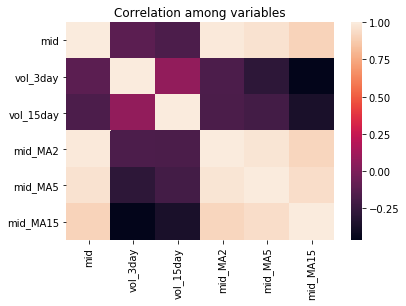

In [70]:
sbs.heatmap(serials)
plt.title('Correlation among variables')
plt.show()

In [34]:
mro_df['returns']=mro_df['low'].pct_change()

In [35]:
autocorrelation=mro_df['returns'].autocorr()

In [36]:
print(autocorrelation)

0.101708746129


The acf function is part of the statsmodels.graphics.tsaplots module

In [37]:
mro_df.head()

,close,high,low,open,time,volumefrom,volumeto,hi_low_log,mid,vol_3day,vol_15day,returns
time,,,,,,,,,,,,
2017-08-17 20:00:00,0.01140,0.01200,0.01103,0.01109,2017-08-17 20:00:00,22082.14,252.50,0.007104,0.011515,0.000000,0.0,NaN
2017-08-18 20:00:00,0.01355,0.01411,0.01140,0.01140,2017-08-18 20:00:00,55518.28,731.48,0.045484,0.012755,0.000000,0.0,0.033545
2017-08-19 20:00:00,0.01349,0.01378,0.01250,0.01355,2017-08-19 20:00:00,26588.46,349.46,0.009504,0.013140,0.086401,0.0,0.096491
2017-08-20 20:00:00,0.01960,0.03187,0.01310,0.01349,2017-08-20 20:00:00,544751.69,11761.97,0.790415,0.022485,0.318808,0.0,0.048000
2017-08-21 20:00:00,0.02218,0.02468,0.01851,0.01960,2017-08-21 20:00:00,304007.90,6636.36,0.082761,0.021595,0.325760,0.0,0.412977


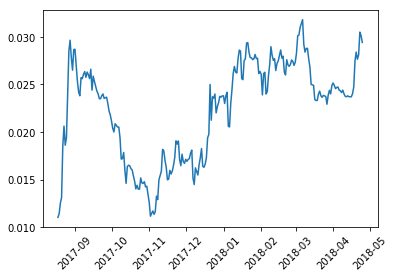

In [38]:
plt.close()
plt.plot(mro_df['low'])
#plt.xticks(mro_df['returns'].index.values)
plt.xticks(rotation=45)
plt.show()

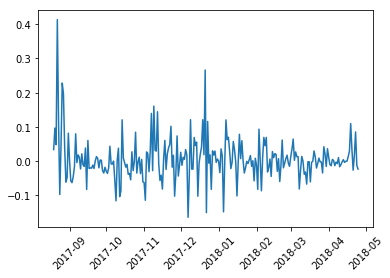

In [39]:
plt.close()
plt.plot(mro_df['returns'])
#plt.xticks(mro_df['returns'].index.values)
plt.xticks(rotation=45)
plt.show()

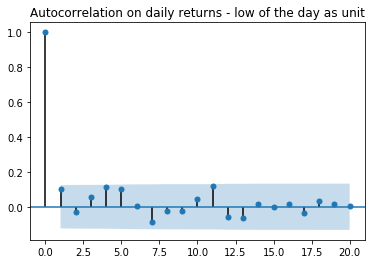

In [40]:
plot_acf(mro_df['returns'][1:],lags=20,alpha=.05)
plt.title('Autocorrelation on daily returns - low of the day as unit')
plt.show()

On the above we see the inclusion of confidence intervals around the autocorrelation calculations. Confidence intervals are the bands above and below zero where a statistically significant divergence from 0 cannot be claimed at 95% confidence. This mechanism makes use of the standard normal distribution and calculates the variance with 0 at the mean - 95% of the spread of distribution is contained within 1.96 times the standard deviation. The standard deviation is calculated as 1/sqrt(N)... N = # of observations. What would be interesting is to extract the confidence bands from the plot_acf function to see if the standard deviation and subsequently the N changes with the differing number of observations.

In [41]:
def calcSD(lag,totalObs):
    instances=totalObs//lag
    calc=1/math.sqrt(instances)
    return((calc*-1.96,calc*1.96))

In [42]:
mro_weekly=mro_df['returns'].resample(how='last',rule='W')

/home/lechuza/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


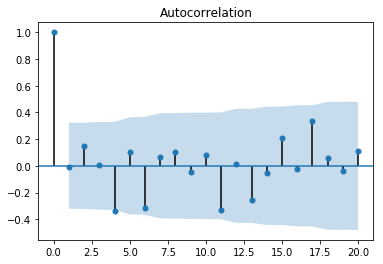

In [43]:
plot_acf(mro_weekly,lags=20,alpha=.05)
plt.show()

The weekly price reduction shows one reliable autocorrelation at the four unit lag observation.

In [44]:
df=mro_df.resample(how='last',rule='W')

/home/lechuza/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


In [45]:
df['returns'].autocorr()

-0.012091772947836796

### When are logs appropriate?
Small changes in the difference of natural logs can be interpreted as percentage changes with a very close approximation. 

In [46]:
math.log(1.05)

0.04879016416943205

Notice how the difference in the logs of the below are very close to the proportional/percentage difference. In this case we take the difference in logs of two numbers that are 5% apart. Recall that you cannot calculate the natural log of a negative number. One practical application is logging data before fitting a random walk. A logged data set yields a so-called geometric random walk--i.e., a random walk with geometric rather than linear growth. A geometric random walk is the default forecasting model that is commonly used for stock price data.

Because changes in the natural logarithm are (almost) equal to percentage changes in the original series, it follows that the slope of a trend line fitted to logged data is equal to the average percentage growth in the original series. 

resource: https://people.duke.edu/~rnau/411log.htm

In [47]:
price_chg=mro_df['low'][1:].as_matrix()/mro_df['low'][:-1].as_matrix()
price_chg[0:4]

array([ 1.03354488,  1.09649123,  1.048     ,  1.4129771 ])

In [48]:
price_log=np.log(price_chg)

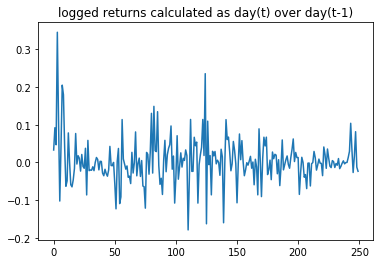

In [49]:
plt.close()
plt.plot(price_log)
plt.title('logged returns calculated as day(t) over day(t-1)')
plt.show()

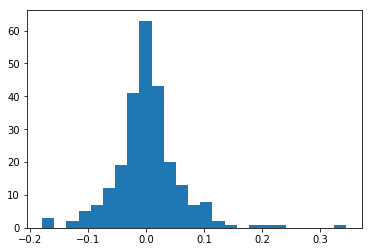

In [50]:
plt.hist(price_log,bins=25)
plt.show()

In [51]:
mro_df.head()

,close,high,low,open,time,volumefrom,volumeto,hi_low_log,mid,vol_3day,vol_15day,returns
time,,,,,,,,,,,,
2017-08-17 20:00:00,0.01140,0.01200,0.01103,0.01109,2017-08-17 20:00:00,22082.14,252.50,0.007104,0.011515,0.000000,0.0,NaN
2017-08-18 20:00:00,0.01355,0.01411,0.01140,0.01140,2017-08-18 20:00:00,55518.28,731.48,0.045484,0.012755,0.000000,0.0,0.033545
2017-08-19 20:00:00,0.01349,0.01378,0.01250,0.01355,2017-08-19 20:00:00,26588.46,349.46,0.009504,0.013140,0.086401,0.0,0.096491
2017-08-20 20:00:00,0.01960,0.03187,0.01310,0.01349,2017-08-20 20:00:00,544751.69,11761.97,0.790415,0.022485,0.318808,0.0,0.048000
2017-08-21 20:00:00,0.02218,0.02468,0.01851,0.01960,2017-08-21 20:00:00,304007.90,6636.36,0.082761,0.021595,0.325760,0.0,0.412977


In [52]:
logs=np.log(mro_df['returns'].as_matrix())

/home/lechuza/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/lechuza/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


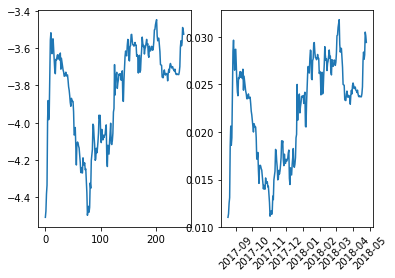

In [53]:
plt.close()
plt.subplot(121)
plt.plot(np.log(mro_df['low'].as_matrix()))
plt.subplot(122)
plt.plot(mro_df['low'])
plt.xticks(rotation=45)
plt.show()

If prices are in logs, then the difference in prices are a good proxy for the percent change in price movement. The difference  in the logs of two different prices is the same as the log ratio of those prices:

math.log(25)-math.log(20) = math.log(25/20)

### Testing for random walk
We make a distinction between a random walk and white noise. A random walk considers the price movement of an asset, while white noise is based on its returns. Today's price is yesterday's price plus some random noise - this is the random walk. White noise on the other hand can be distribution based - whereas deviations from historical returns can be compared to a mathematical/statistical distribution.
Regress prices on a lag price. If the coefficient is not significantly different from 1, then we cannot reject the null hypothesis that it is a random walk. You can also apply a **Dickey-Fuller** test.

In [54]:
from statsmodels.tsa.stattools import adfuller

In [55]:
results=adfuller(mro_df['low'])
print('the p-value is {}'.format(results[1]))
print('This does not meet the 5% significance level, and so we cannot reject the null hypothesis that prices follow a random walk')

the p-value is 0.17442512648448877
This does not meet the 5% significance level, and so we cannot reject the null hypothesis that prices follow a random walk


### Stationarity
There is strong form and semi-strong form - where the mean and variance are independent of time. White noise is stationary. Random walk is actually not stationary as the variance increases with time: we know a lot less about the possible values of a series a time far off in the future than we do one nearer in time. Lack of stationarity does not lend itself to modeling as the number of parameters is great to account for the changing nature of the mean and variance. We can make adjustments/transformations to the series to make it stationary. These include a mix of lag differences (appropriate for series with seasonalities) and log transforms to remove trended data.

### Using the autocorr
Autocorrelation tests for correlation of a time series lagging the independent variable. A statistically significant autocorrelation statistic implies the absence of white noise... there is a non-random component to the path of returns. Removing this seasonality from the time series with a diff() application, can turn the series stationary. This can be tested by re-running the autocorr function acf().